# Build the watershed model

In [34]:
import matplotlib.pyplot as plt
import pathlib as pl
import flopy
from flopy.discretization import StructuredGrid

In [35]:
from defaults import *

In [36]:
model_dir = get_base_dir()

### Load the topology

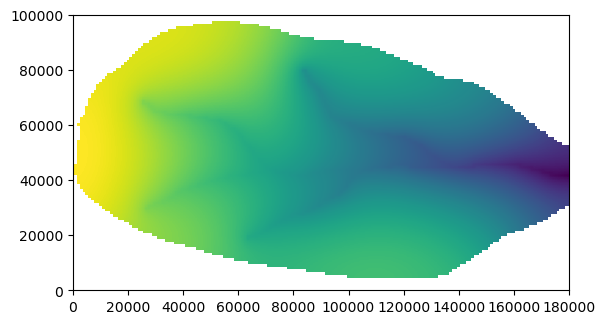

In [37]:
fine_topo = flopy.utils.Raster.load("../../data/Parallel_MODFLOW/fine_topo.asc")
_ = fine_topo.plot()

### Parallel settings

1. Set `path_to_mf6` to the path of parallel MODFLOW 6 (`path\to\mf6`) if it is not in your `PATH` otherwise set to `None`.

In [38]:
path_to_mf6 = pl.Path.home() / ".local/bin/mf6"

### Structured grid parameters

Set the cell dimensions. This will determine the number of cells in the grid, setting dx = dy = 2500.0 will lead to 9595 active cells

In [39]:
dx = dy = 2500.0
nrow = int(Ly / dy) + 1
ncol = int(Lx / dx) + 1

### Read in boundary data

Load the boundary data from `defaults.py` and plot

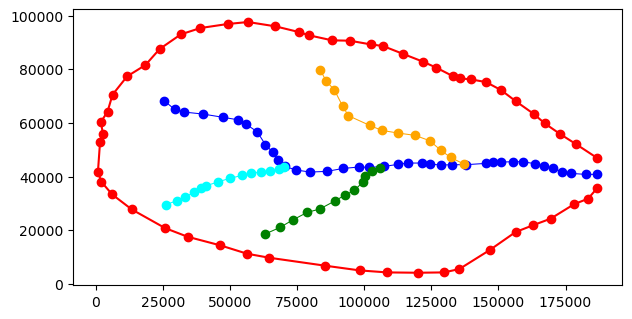

In [40]:
boundary_polygon = string2geom(geometry["boundary"])
bp = np.array(boundary_polygon)

stream_segs = (
    geometry["streamseg1"],
    geometry["streamseg2"],
    geometry["streamseg3"],
    geometry["streamseg4"],
)
sgs = [string2geom(sg) for sg in stream_segs]


fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
ax.set_aspect("equal")

riv_colors = ("blue", "cyan", "green", "orange", "red")

ax.plot(bp[:, 0], bp[:, 1], "ro-")
for idx, sg in enumerate(sgs):
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], color=riv_colors[idx], lw=0.75, marker="o")

### Create a structured grid

In [41]:
working_grid = StructuredGrid(
    nlay=1,
    delr=np.full(ncol, dx),
    delc=np.full(nrow, dy),
    xoff=0.0,
    yoff=0.0,
    top=np.full((nrow, ncol), 1000.0),
    botm=np.full((1, nrow, ncol), -100.0),
)

set_structured_idomain(working_grid, boundary_polygon)
print("grid data: ", Lx, Ly, nrow, ncol)

grid data:  180000 100000 41 73


### Sample the raw topographic data

In [42]:
top_wg = fine_topo.resample_to_grid(
    working_grid,
    band=fine_topo.bands[0],
    method="linear",
    extrapolate_edges=True,
)

### Intersect river segments with grid

In [43]:
ixs, cellids, lengths = intersect_segments(working_grid, sgs)

### Plot the river intersection

In [44]:
intersection_rg = np.zeros(working_grid.shape[1:])
for loc in cellids:
    intersection_rg[loc] = 1

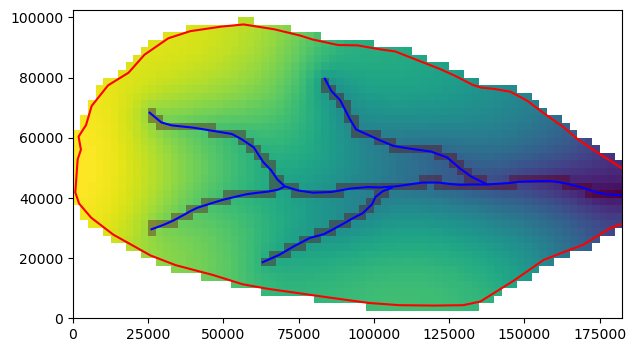

In [45]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot()
pmv = flopy.plot.PlotMapView(modelgrid=working_grid)
ax.set_aspect("equal")
pmv.plot_array(top_wg)
pmv.plot_array(
    intersection_rg,
    masked_values=[
        0,
    ],
    alpha=0.2,
    cmap="Reds_r",
)
pmv.plot_inactive(color_noflow="white")
ax.plot(bp[:, 0], bp[:, 1], "r-")
for sg in sgs:
    sa = np.array(sg)
    ax.plot(sa[:, 0], sa[:, 1], "b-")

### Set the idomain value to 2 where the river intersects the grid

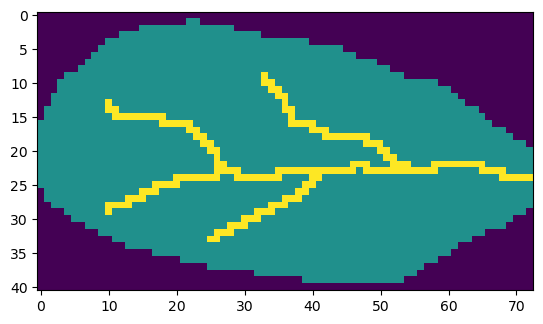

In [46]:
river_locations = working_grid.idomain[0].copy()
index = tuple(np.array(list(zip(*cellids))))
river_locations[index] = 2
working_grid.idomain = river_locations.reshape(1, nrow, ncol)

plt.imshow(working_grid.idomain[0])

### Define the number of layers and the thickness of layer 1

In [47]:
nlay = 5
dv0 = 5.0

### Create the drain data for the river segments

In [48]:
leakance = 1.0 / (0.5 * dv0)  # kv / b
drn_data = build_drain_data(
    working_grid,
    cellids,
    lengths,
    leakance,
    top_wg,
)
drn_data[:10]

[(0, 24, 72, 1.111111044883728, 4914.076262408451),
 (0, 24, 71, 2.349671334028244, 5109.1918417828165),
 (0, 24, 70, 3.691406548023224, 5370.879366670653),
 (0, 24, 69, 5.182320833206177, 5711.943682902942),
 (0, 24, 68, 8.88231897354126, 1192.0000224733192),
 (0, 23, 68, 7.197898030281067, 4829.869910004271),
 (0, 23, 67, 7.517921805381775, 6080.301756035172),
 (0, 23, 66, 8.840358018875122, 6266.099788854482),
 (0, 23, 65, 11.588606595993042, 5915.186176826305),
 (0, 22, 65, 12.860051155090332, 492.51242187967165)]

### Create the groundwater discharge drain data

In [60]:
gw_discharge_data = build_groundwater_discharge_data(
    working_grid,
    leakance,
    top_wg,
)
gw_discharge_data[:10]

[(0, 1, 22, 95.37101745605469, 2500000.0, 1.0),
 (0, 1, 23, 94.59060668945312, 2500000.0, 1.0),
 (0, 2, 15, 100.11952209472656, 2500000.0, 1.0),
 (0, 2, 16, 99.64676666259766, 2500000.0, 1.0),
 (0, 2, 17, 99.08812713623047, 2500000.0, 1.0),
 (0, 2, 18, 98.61627960205078, 2500000.0, 1.0),
 (0, 2, 19, 97.92719078063965, 2500000.0, 1.0),
 (0, 2, 20, 97.12367057800293, 2500000.0, 1.0),
 (0, 2, 21, 96.33317184448242, 2500000.0, 1.0),
 (0, 2, 22, 95.40703964233398, 2500000.0, 1.0)]

### Create the top and bottom arrays.

Top array is not used by the model.

In [50]:
topc = np.zeros((nlay, nrow, ncol), dtype=float)
botm = np.zeros((nlay, nrow, ncol), dtype=float)
dv = dv0
topc[0] = top_wg.copy()
botm[0] = topc[0] - dv
for idx in range(1, nlay):
    dv *= 1.5
    topc[idx] = botm[idx - 1]
    botm[idx] = topc[idx] - dv

#### Print the cell thicknesses

In [51]:
for k in range(nlay):
    print((topc[k] - botm[k]).mean())

5.0
7.5
11.25
16.875
25.3125


### Create idomain and starting head data

In [52]:
idomain = np.array([working_grid.idomain[0, :, :].copy() for k in range(nlay)])
strt = np.array([top_wg.copy() for k in range(nlay)], dtype=float)

## Build the model files using FloPy

In [53]:
sim = flopy.mf6.MFSimulation(
    sim_ws=model_dir,
    exe_name="mf6",
    memory_print_option="summary",
)

tdis = flopy.mf6.ModflowTdis(sim)
ims = flopy.mf6.ModflowIms(
    sim,
    complexity="simple",
    print_option="SUMMARY",
    csv_outer_output_filerecord="outer.csv",
    csv_inner_output_filerecord="inner.csv",
    linear_acceleration="bicgstab",
    outer_maximum=1000,
    inner_maximum=100,
    outer_dvclose=1e-4,
    inner_dvclose=1e-5,
    preconditioner_levels=2,
    relaxation_factor=0.0,
)
gwf = flopy.mf6.ModflowGwf(
    sim,
    print_input=True,
    save_flows=True,
    newtonoptions="NEWTON UNDER_RELAXATION",
)

dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=dx,
    delc=dy,
    idomain=idomain,
    top=top_wg,
    botm=botm,
    xorigin=0.0,
    yorigin=0.0,
)

ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_specific_discharge=True,
    icelltype=1,
    k=1.0,
)
rch = flopy.mf6.ModflowGwfrcha(
    gwf,
    recharge=0.000001,
)
drn = flopy.mf6.ModflowGwfdrn(
    gwf,
    stress_period_data=drn_data,
    pname="river",
    filename="drn_riv.drn",
)
drn_gwd = flopy.mf6.ModflowGwfdrn(
    gwf,
    auxiliary=["depth"],
    auxdepthname="depth",
    stress_period_data=gw_discharge_data,
    pname="gwd",
    filename="drn_gwd.drn",
)
oc = flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{gwf.name}.hds",
    budget_filerecord=f"{gwf.name}.cbc",
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("BUDGET", "ALL")],
)

### Count the number of active cells

In [54]:
ncells, nactive = get_simulation_cell_count(sim)
print("nr. of cells:", ncells, ", active:", nactive)

nr. of cells: 14965 , active: 9595


### Write the model files

In [55]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model model...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha_0...
    writing package river...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 169 based on size of stress_period_data
    writing package gwd...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 1919 based on size of stress_period_data
    writing package oc...


### Run the model

In [56]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../modflow6-mjr/bin/mf6
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 02/13/2024
                               ***DEVELOP MODE***

        MODFLOW 6 compiled May 22 2024 09:10:18 with GCC version 11.4.0

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.S. Government shall be held 
liable for any damages resulting from the authorized or unauthorized 
use of th

(True, [])

### Plot results

In [57]:
gwf = sim.get_model()
times = gwf.output.head().get_times()
base_head = np.squeeze(gwf.output.head().get_data(totim=times[-1]))

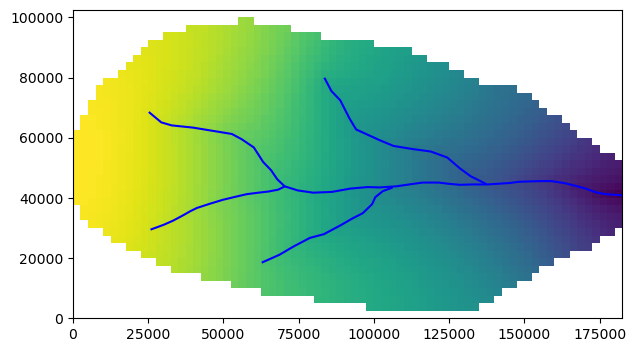

In [58]:
fig = plt.figure(figsize=figsize)
pmv = flopy.plot.PlotMapView(model=gwf, layer=0)
pmv.plot_array(base_head)

for sg in sgs:
    sa = np.array(sg)
    pmv.ax.plot(sa[:, 0], sa[:, 1], "b-")